In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
df=pd.read_csv("Alcohol_Sales.csv",index_col=0,parse_dates=True)

In [7]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [8]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [9]:
len(df)

325

In [10]:
df=df.dropna()

In [11]:
len(df)

325

<AxesSubplot:xlabel='DATE'>

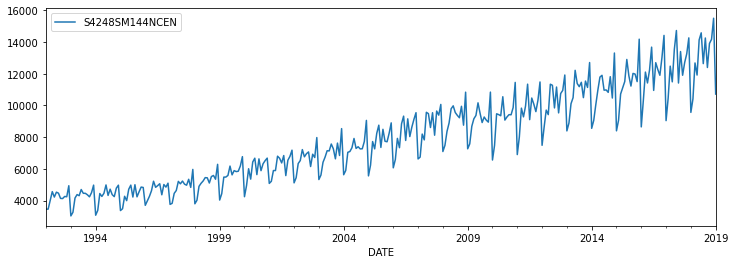

In [13]:
df.plot(figsize=(12,4))

In [14]:
y=df["S4248SM144NCEN"].values.astype(float)

In [16]:
test_size=12 # a year

In [20]:
train_set=y[:-test_size]
print(len(train_set))
test_set=y[-test_size:]
print(len(test_set))

313
12


In [21]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1,1)) # -1 ile 1 arasında minmaxscaler yapcak


In [22]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [23]:
train_norm=scaler.transform(train_set.reshape(-1,1))

In [25]:
train_norm=torch.FloatTensor(train_norm).view(-1)

In [26]:
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [27]:
window_size=12
def input_data(seq,ws):
    out=[]
    L=len(seq)
    
    for i in range(L-ws):
        window=seq[i:i+ws]
        label=seq[i+ws:i+ws+1]
        
        out.append((window,label))
        
    return out
        
        

In [28]:
train_data=input_data(train_norm,window_size)


In [29]:
len(train_data)

301

In [30]:
325-12-12

301

In [31]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [42]:
class LSTMNetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        
        self.hidden_size=hidden_size
        
        # Add Lstm Layer
        self.lstm=nn.LSTM(input_size,hidden_size)
        self.linear=nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0
        self.hidden=(torch.zeros(1,1,self.hidden_size),
                     torch.zeros(1,1,self.hidden_size))
        
    def forward(self,seq):
        lstm_out,self.hidden=self.lstm(
                seq.view(len(seq),1,-1),
                self.hidden)
            
        pred=self.linear(lstm_out.view(len(seq),-1))
            
        return pred[-1] # We only want the LAST VALUE

In [43]:
model=LSTMNetwork()
epochs=100
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [44]:
model

LSTMNetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [45]:

for epoch in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden=(torch.zeros(1,1,model.hidden_size),
                      torch.zeros(1,1,model.hidden_size))
        y_pred=model(seq)
        
        loss=criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
    print("Epoch {} Loss {} ".format(epoch,loss.item()))
    
        

Epoch 0 Loss 0.34694063663482666 
Epoch 1 Loss 0.4690070152282715 
Epoch 2 Loss 0.36079490184783936 
Epoch 3 Loss 0.39911001920700073 
Epoch 4 Loss 0.3178984522819519 
Epoch 5 Loss 0.3343987762928009 
Epoch 6 Loss 0.30931729078292847 
Epoch 7 Loss 0.3296685218811035 
Epoch 8 Loss 0.5320534706115723 
Epoch 9 Loss 0.30580535531044006 
Epoch 10 Loss 0.2927592396736145 
Epoch 11 Loss 0.3308621942996979 
Epoch 12 Loss 0.29395270347595215 
Epoch 13 Loss 0.2500832676887512 
Epoch 14 Loss 0.15012526512145996 
Epoch 15 Loss 0.20567290484905243 
Epoch 16 Loss 0.12203505635261536 
Epoch 17 Loss 0.11196573823690414 
Epoch 18 Loss 0.062292806804180145 
Epoch 19 Loss 0.039820346981287 
Epoch 20 Loss 0.03521563112735748 
Epoch 21 Loss 0.027973242104053497 
Epoch 22 Loss 0.030563024803996086 
Epoch 23 Loss 0.03294108808040619 
Epoch 24 Loss 0.02409966103732586 
Epoch 25 Loss 0.027755070477724075 
Epoch 26 Loss 0.026068026199936867 
Epoch 27 Loss 0.017894769087433815 
Epoch 28 Loss 0.013485346920788288

In [46]:
future=12
preds=train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq=torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        

In [47]:
preds[window_size:]

[0.6394892334938049,
 0.5954546332359314,
 0.5768162608146667,
 1.0228934288024902,
 0.9567007422447205,
 0.36725956201553345,
 0.9914953112602234,
 0.41994708776474,
 0.9542185664176941,
 0.626181423664093,
 1.0369696617126465,
 0.35432207584381104]

In [54]:
true_prediction=scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [55]:
true_prediction

array([[12621.19227132],
       [12363.61187711],
       [12254.58671764],
       [14863.91511178],
       [14476.72099176],
       [11028.78480801],
       [14680.25182322],
       [11336.98048988],
       [14462.20150426],
       [12543.34823772],
       [14946.25403619],
       [10953.10698265]])

In [56]:
df["S4248SM144NCEN"][-window_size:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [72]:
x=np.arange("2018-02-01","2019-02-01",dtype="datetime64[M]")

In [73]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [76]:
p = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
p

array(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
       '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01'],
      dtype='datetime64[D]')

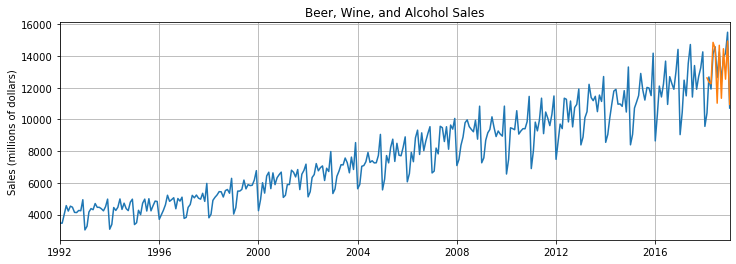

In [74]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_prediction)
plt.show()

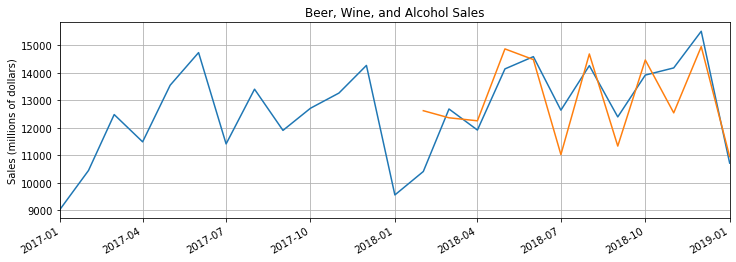

In [75]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_prediction)
plt.show()

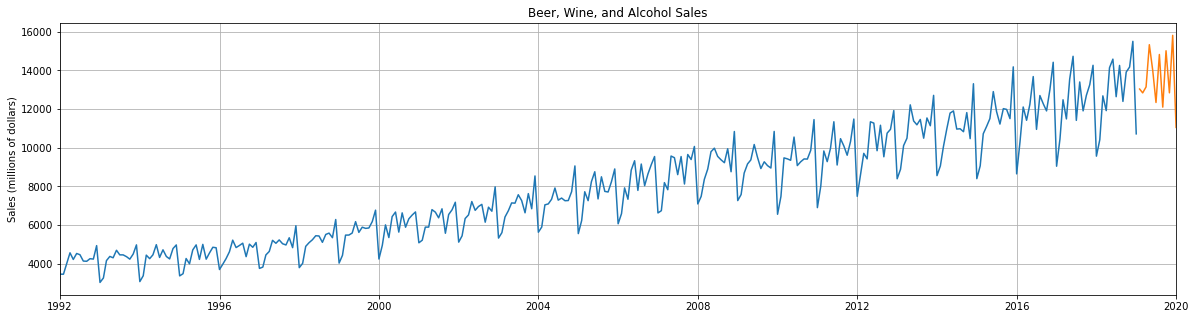

In [77]:

plt.figure(figsize=(20,5))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(p,true_predictions[window_size:])
plt.show()

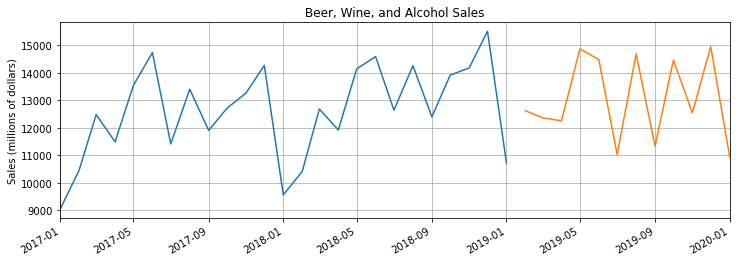

In [79]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(p,true_prediction)
plt.show()